In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [3]:
from tqdm import tqdm_notebook

Why is vectorization prefered?

1. It reduces time of execution drastically by exploititng parallelism
2. Code length reduces drastically

SIMD (Single Instruction Multiple Data) Instructions

SIMD (Single Instruction Multiple Data) is an instruction set available mostly on all current processors. SIMD instructions give data-level parallelism on a unit (vector of data). A single instruction is executed in parallel on multiple data points as opposed to executing multiple instructions. This improves the performance of application.

Consider two arrays A and B that store integers. You want to sum corresponding elements in A and B and store the results in array C:

something like C[i] = A[i] + B[i] in a loop.

In every iteration of the loop there will be 2 load, 1 store and 1 add instruction. I am obviously glossing over effects of CPU caching to explain the topic.

Doing the same work leveraging SIMD instruction set will take less number of CPU instructions since each instruction will process multiple elements. To be specific, with SIMD instruction set that has 128 bit register, we can do the processing on 4 integers at a time:

a)A single load instruction to get 4 values of A into a 128 bit SIMD register

b)A single load instruction to get 4 values of B into a 128 bit SIMD register

c)A single add instruction to add corresponding values in both register.

Source : https://www.quora.com/What-is-SIMD/answer/Siddharth-Teotia

In [4]:
rows  = 100
col = 50
a = np.random.randn(rows,col)
b = np.random.randn(rows,col)
c = np.zeros((rows,col))


In [5]:
%%time

for i in range(rows):
    for j in range(col):
        c[i,j] = a[i,j] + b[i,j]

Wall time: 24 ms


In [6]:
%%time 

c= a + b


Wall time: 0 ns


Notice the difference in times. Numpy internally does parallelism to execute code faster

In [7]:
%%time

for i in range(rows):
    for j in range(col):
        c[i,j] = np.sin(a[i,j])

Wall time: 48.2 ms


In [8]:
%%time

c = np.sin(a)

Wall time: 0 ns


operation overloading broadcasting

<h3> FF Neural Network Class </h3>

In [9]:
class FeedForwardNeuralNetwork:
    def __init__(self):
        self.W1 = np.random.randn(2,2) #first weight matrix
        self.W2 = np.random.randn(2,4) #second weight matrix
        self.B1 = np.zeros((1,2))
        self.B2 = np.zeros((1,4))
   
    def sigmoid(self,x):
        
        return 1.0/(1.0 + np.exp(-x))
        
    def softmax(self,x):
        exps = np.exp(x) # each element of vector x is raised to the power of e
        return exps/np.sum(exps)
    
    def forward_pass(self,x):
        x = x.reshape(1,-1) # reshape such that x becomes a single row
        self.A1 = np.matmul(x,self.W1) + self.B1#(1,2)
        self.H1 = self.sigmoid(self.A1) #(1,2)
        self.A2 = np.matmul(self.H1, self.W2) + self.B2#(1,4)
        self.H2 = self.softmax(self.A2)#(1,4)
        
        return self.H2
    
    def grad_sigmoid(self,x):
        return x*(1-x)
    
    def grad(self, x ,y):
        self.forward_pass(x)
        x = x.reshape(1,-1)
        y = y.reshape(1,-1)
        
        self.dA2 = self.H2 - y # (1,4) - (1,4) => (1,4)
        
        self.dW2 = np.matmul(self.H1.T , self.dA2) # (2,1) * (1,4) => (2,4) 
        self.dB2 = self.dA2 # (1,4)
        self.dH1 = np.matmul(self.dA2, self.W2.T ) # (1,4 )  *(4 ,2)   => (1,2)
        # np.multiply does element wise multiplication i.e Hadamard product
        self.dA1 = np.multiply(self.dH1 , self.grad_sigmoid(self.H1)) # (1,2)
        #self.dW1 = np.matmul(self.dA1.T ,x) #(2,1) * (1,2) => 2*2
        self.dW1 = np.matmul(x.T , self.dA1) #(2,1) * (1,2) => (2*2)
        
        self.dB1 = self.dA1
 
    def fit(self, X, Y, epochs=1, learning_rate=1, display_loss=False):
      
        if display_loss:
            loss = {}
    
        for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
            dW1 = np.zeros((2,2))
            dW2 = np.zeros((2,4))
            dB1 = np.zeros((1,2))
            dB2 = np.zeros((1,4))
            for x, y in zip(X, Y):
                self.grad(x, y)
                dW1 += self.dW1
                dW2 += self.dW2
                dB1 += self.dB1
                dB2 += self.dB2  
        
            m = X.shape[0]
            self.W2 -= learning_rate * (dW2/m)
            self.B2 -= learning_rate * (dB2/m)
            self.W1 -= learning_rate * (dW1/m)
            self.B1 -= learning_rate * (dB1/m)
 
            if display_loss:
                Y_pred = self.predict(X)
                loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
        
    
        if display_loss:
            plt.plot(loss.values())
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()

    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.forward_pass(x)
            Y_pred.append(y_pred)
        return np.array(Y_pred).squeeze()

NOTE: In np.matmul use dimensions to decide which is the first and which is the second input to the function

In [10]:
#np.matmul(np.array([1,2]),np.array([[1,0],[0,1]]))

<h3> Generate Data </h3>

In [11]:
make_blobs(n_samples = 7, centers = 3, n_features = 3) 

(array([[-0.31448666, -2.82038836, -5.65319622],
        [-1.24453408, -3.99600414,  1.58246113],
        [ 2.76675082, -0.63238913, -2.33082522],
        [-1.94536167, -4.07701661, -4.21013878],
        [ 0.96389246, -2.97984333, -0.536916  ],
        [ 0.49376042, -3.30574696, -3.68546509],
        [-3.24921037, -4.6021277 ,  2.98530781]]),
 array([0, 2, 1, 0, 1, 0, 2]))

In [12]:
data, labels = make_blobs(n_samples = 800, centers = 4 , n_features = 2)

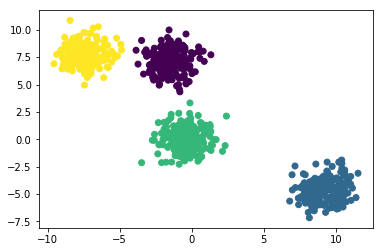

In [13]:
plt.scatter(data[:,0],data[:,1] , c=labels)
            

<h3> Training FF Neural Network and Using Model </h3>

In [14]:
X_train,X_val, Y_train, Y_val =  train_test_split(data,labels, test_size = 0.2, stratify = labels)

In [15]:
from sklearn.preprocessing import OneHotEncoder

We have to one hot encode the output before we feed it to the neural network for training

In [16]:
enc = OneHotEncoder()

In [17]:
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
Y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
# 1 => (1,0,0,0)
# 2 => (0,1,0,0)
# 3 => (0,0,1,0)

c:\users\dell\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
c:\users\dell\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence thi

In [18]:
ffnn = FeedForwardNeuralNetwork()

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

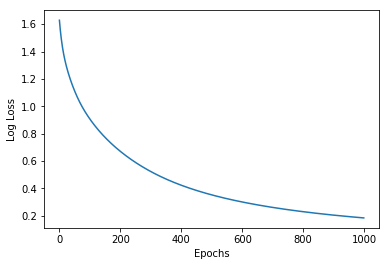

In [19]:
ffnn.fit(X_train, Y_OH_train, epochs = 1000, learning_rate = 0.1 , display_loss=True)

In [20]:
Y_pred_train = ffnn.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = ffnn.predict(X_val)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_val = accuracy_score(Y_pred_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.98
Validation accuracy 0.98


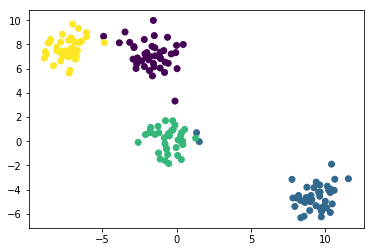

In [21]:
plt.scatter(X_val[:,0],X_val[:,1], c= Y_pred_val)

In [22]:
np.argmax([[1,0,0],[2,3,4],[0,5,2]],axis = 0) # Gives index of maximum element in each column

array([1, 2, 1], dtype=int32)

In [23]:
np.argmax([[1,0,0],[2,3,4],[0,5,2]],axis = 1) # Gives index of the maximum element in each row

array([0, 2, 1], dtype=int32)

Axes are defined for arrays with more than one dimension. A 2-dimensional array has two corresponding axes: the first running vertically downwards across rows (axis 0), and the second running horizontally across columns (axis 1). ... Collapsed to a one-dimensional array. See numpy.ndarray.flatten for details.
